inspired by https://www.youtube.com/watch?v=OZJ1IgSgP9E&list=PLV8yxwGOxvvovp-j6ztxhF3QcKXT6vORU

In [94]:
import pandas as pd
# Makes sure we see all columns
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

class DataLoader():
    def __init__(self):
        self.data = None

    def load_dataset(self, path="data/healthcare-dataset-stroke-data.csv"):
        self.data = pd.read_csv(path)

    def preprocess_data(self):
        # One-hot encode all categorical columns
        categorical_cols = ["gender",
                            "ever_married",
                            "work_type",
                            "Residence_type",
                            "smoking_status"]
        encoded = pd.get_dummies(self.data[categorical_cols],
                                prefix=categorical_cols)

        # Update data with new columns
        self.data = pd.concat([encoded, self.data], axis=1)
        self.data.drop(categorical_cols, axis=1, inplace=True)

        # Impute missing values of BMI
        self.data.bmi = self.data.bmi.fillna(0)

        # Drop id as it is not relevant
        self.data.drop(["id"], axis=1, inplace=True)

        # Standardization
        # Usually we would standardize here and convert it back later
        # But for simplification we will not standardize / normalize the features

    def get_data_split(self):
        X = self.data.iloc[:,:-1]
        y = self.data.iloc[:,-1]
        return train_test_split(X, y, test_size=0.20, random_state=2021)

    def oversample(self, X_train, y_train):
        oversample = RandomOverSampler(sampling_strategy='minority')
        # Convert to numpy and oversample
        x_np = X_train.to_numpy()
        y_np = y_train.to_numpy()
        x_np, y_np = oversample.fit_resample(x_np, y_np)
        # Convert back to pandas
        x_over = pd.DataFrame(x_np, columns=X_train.columns)
        y_over = pd.Series(y_np, name=y_train.name)
        return x_over, y_over


In [95]:
from google.colab import drive
drive.mount('/content/drive')

data_loader = DataLoader()
# Replace 'your_file_path_here.csv' with the actual path to your file on Google Drive
data_loader.load_dataset(path='/content/drive/MyDrive/healthcare-dataset-stroke-data.csv')

# Display the first few rows of the loaded data to confirm
print(data_loader.data.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   


In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score


# %% Load and preprocess data
data_loader = DataLoader()
data_loader.load_dataset(path='/content/drive/MyDrive/healthcare-dataset-stroke-data.csv')
data_loader.preprocess_data()
# Split the data for evaluation
X_train, X_test, y_train, y_test = data_loader.get_data_split()
# Oversample the train data
X_train, y_train = data_loader.oversample(X_train, y_train)
print(X_train.shape)
print(X_test.shape)


(7778, 21)
(1022, 21)


In [97]:

data_loader.data.head()

gender_Female  gender_Male  gender_Other  ever_married_No  \
0          False         True         False            False   
1           True        False         False            False   
2          False         True         False            False   
3           True        False         False            False   
4           True        False         False            False   

   ever_married_Yes  work_type_Govt_job  work_type_Never_worked  \
0              True               False                   False   
1              True               False                   False   
2              True               False                   False   
3              True               False                   False   
4              True               False                   False   

   work_type_Private  work_type_Self-employed  work_type_children  \
0               True                    False               False   
1              False                     True               False   
2               True                    False               False   
3               True                    False               False   
4              False                     True               False   

   Residence_type_Rural  Residence_type_Urban  smoking_status_Unknown  \
0                 False                  True                   False   
1                  True                 False                   False   
2                  True                 False                   False   
3                 False                  True                   False   
4                  True                 False                   False   

   smoking_status_formerly smoked  smoking_status_never smoked  \
0                            True                        False   
1                           False                         True   
2                           False                         True   
3                           False                        False   
4                           False                         True   

   smoking_status_smokes   age  hypertension  heart_disease  \
0                  False  67.0             0              1   
1                  False  61.0             0              0   
2                  False  80.0             0              1   
3                   True  49.0             0              0   
4                  False  79.0             1              0   

   avg_glucose_level   bmi  stroke  
0             228.69  36.6       1  
1             202.21   0.0       1  
2             105.92  32.5       1  
3             171.23  34.4       1  
4             174.12  24.0       1

# **LIME**

In [98]:
#use logistic regression instead
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")


F1 Score 0.5198064679528047
Accuracy 0.7367906066536204


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [99]:
pip install lime

In [111]:
from lime.lime_tabular import LimeTabularExplainer

# Create LIME explainer
# Convert X_train to numpy array for LimeTabularExplainer and provide feature names
explainer_lime = LimeTabularExplainer(
    X_train.values,  # Convert DataFrame to NumPy array
    feature_names=X_train.columns.tolist(), # Provide feature names from original DataFrame
    class_names=['no stroke', 'stroke'], # Assuming these are the class names for a binary classification
    mode="classification"
)

# Pick one test instance
i = 12 #12
# Select a row from X_test using .iloc and convert to numpy array
test_instance = X_test.iloc[i].values


# Generate explanation
exp_lime = explainer_lime.explain_instance(
    test_instance,
    lr.predict_proba, # This is the crucial change: using predict_proba
    num_features=7
)

# Show explanation
exp_lime.show_in_notebook()

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


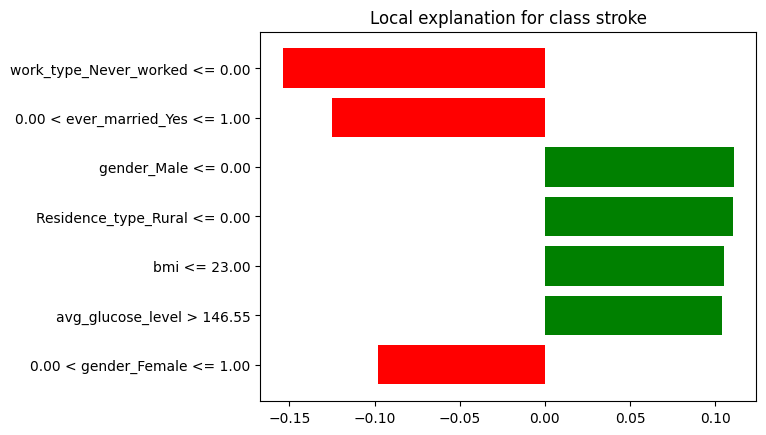

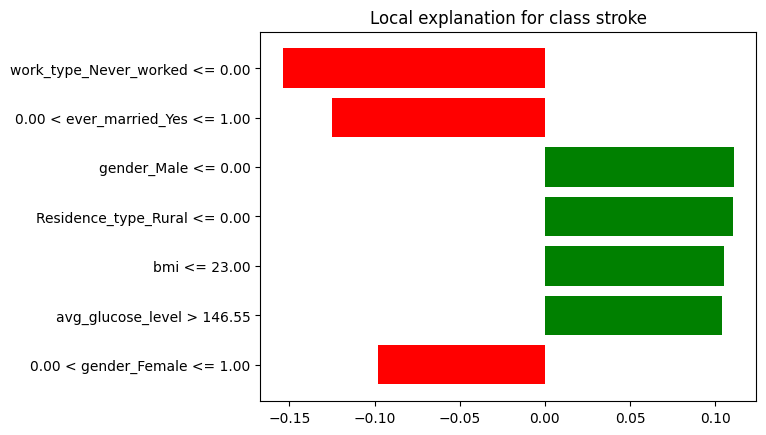

In [101]:
exp_lime.as_pyplot_figure()

# **SHAP**

In [102]:
pip install shap

In [105]:
import shap

# Define a prediction function
def predict_fn(x):
    return lr.predict(x)

# Create SHAP explainer
explainer = shap.KernelExplainer(predict_fn, X_train[:200],feature_names=X_train.columns)  # use a subset for speed

# Compute SHAP values for test set
shap_values = explainer.shap_values(X_test[:100])  # first 100 samples for demonstration

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist

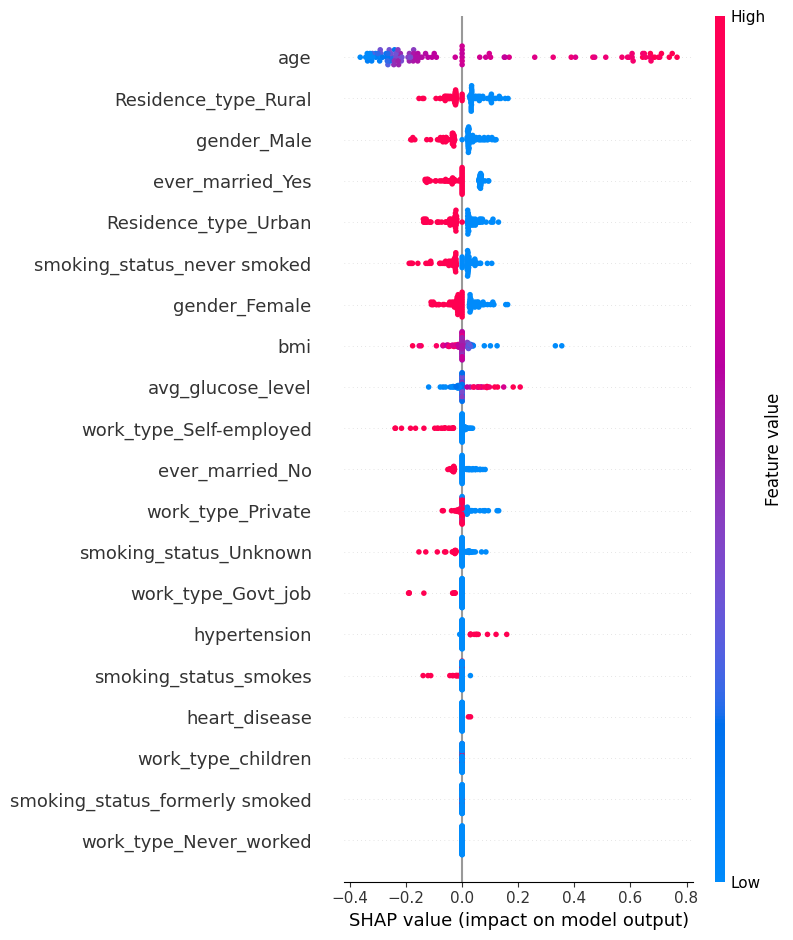

In [106]:
shap.summary_plot(shap_values, X_test[:100], feature_names=X_test.columns)

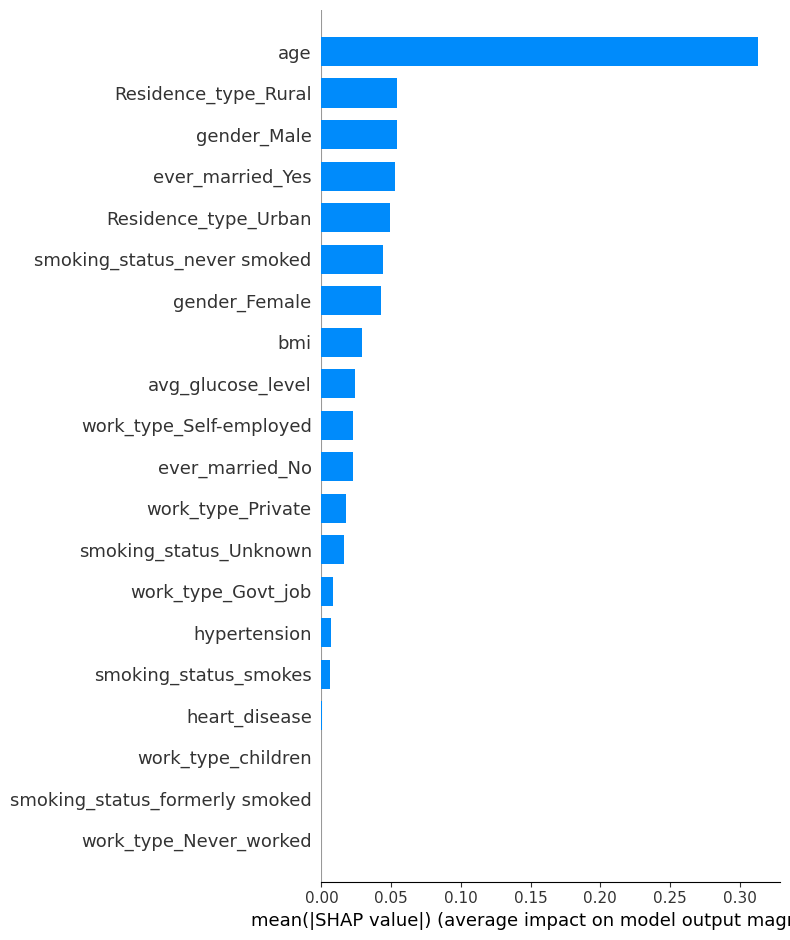

In [107]:
shap.summary_plot(shap_values, X_test[:100], feature_names=X_test.columns, plot_type="bar")


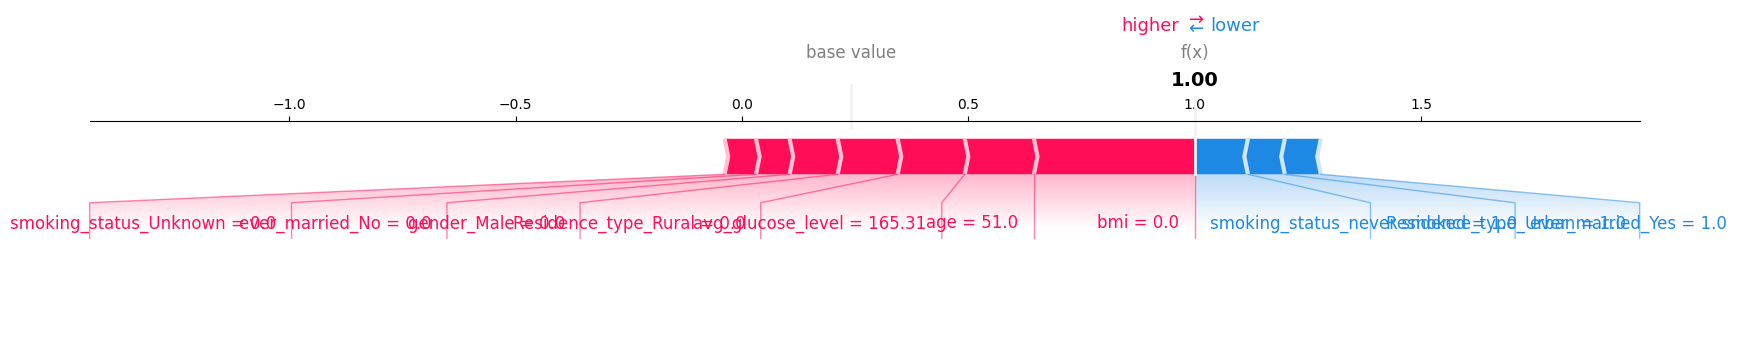

In [108]:
# Choose ith test instance
i=12 #12
shap.force_plot(
    explainer.expected_value,
    shap_values[i],
    X_test.iloc[i],
    feature_names=X_test.columns,
    matplotlib=True
)

In [112]:
#re-visiting lime
test_instance = X_test.iloc[i].values


# Generate explanation
exp_lime = explainer_lime.explain_instance(
    test_instance,
    lr.predict_proba,
    num_features=7
)

# Show explanation
exp_lime.show_in_notebook()

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


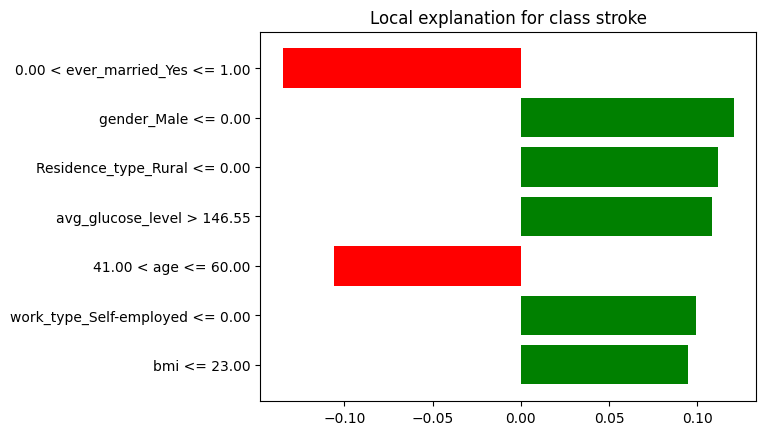

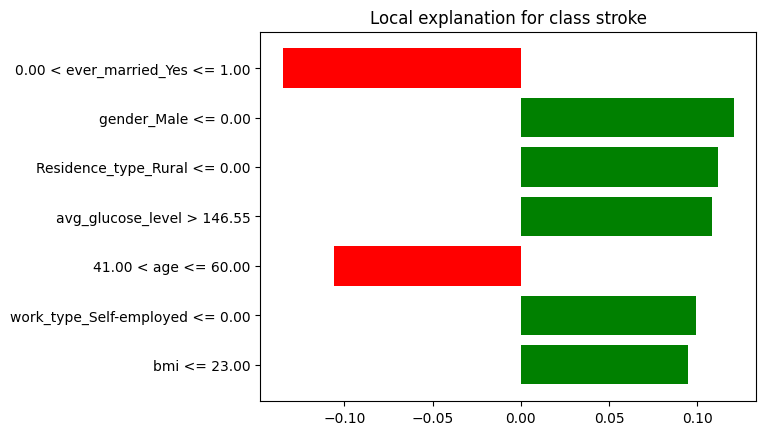

In [113]:
exp_lime.as_pyplot_figure()

In [115]:
X_test.iloc[i]

gender_Female                       True
gender_Male                        False
gender_Other                       False
ever_married_No                    False
ever_married_Yes                    True
work_type_Govt_job                 False
work_type_Never_worked             False
work_type_Private                   True
work_type_Self-employed            False
work_type_children                 False
Residence_type_Rural               False
Residence_type_Urban                True
smoking_status_Unknown             False
smoking_status_formerly smoked     False
smoking_status_never smoked         True
smoking_status_smokes              False
age                                 51.0
hypertension                           0
heart_disease                          0
avg_glucose_level                 165.31
bmi                                  0.0
Name: 78, dtype: object